In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # for the activation function

import torchvision
import torchvision.transforms as transforms
import numpy as np

LOAD = True
CLEAR_CACHE = False

batch_size = 256
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train_data = torchvision.datasets.CIFAR10(
    './data',
    train=True,
    download=True,
    transform=transform,
)
cifar_test_data = torchvision.datasets.CIFAR10(
    './data',
    train=False,
    download=True,
    transform=transform,
)

cifar_train_dl = torch.utils.data.DataLoader(cifar_train_data, batch_size=batch_size, shuffle=True)
cifar_test_dl = torch.utils.data.DataLoader(cifar_test_data, batch_size=batch_size)

import os
try:
    os.mkdir('models')
except FileExistsError:
    pass

c:\Users\matth\.conda\envs\sklearn-env\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\matth\.conda\envs\sklearn-env\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


Files already downloaded and verified
Files already downloaded and verified


In [56]:
import copy

# Evaluation: compute the accuracy on test set
def test(model, test_dl):
   model.eval()
   accuracy = 0
   with torch.no_grad():
       for (X, y) in test_dl:
           X, y = X.to('cuda'), y.to('cuda')
           pred = model(X)
           accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
       #
   return accuracy / len(test_dl.dataset)
#

# expects an already trained model
def get_forgettables(model, dataset):
   forgettables_ds = copy.deepcopy(dataset)
   unforgettables_ds = copy.deepcopy(dataset)

   forgettables_ds.data = []
   forgettables_ds.targets = []
   unforgettables_ds.data = []
   unforgettables_ds.targets = []

   dummy_dl = torch.utils.data.DataLoader(dataset, batch_size=1)

   model.eval()
   i = 0
   with torch.no_grad():
      for (i, (X, y)) in enumerate(dummy_dl):
         X, y = X.to('cuda'), y.to('cuda')

         pred = model(X)
         pred = torch.argmax(pred,dim=1)
         if pred == y:
            unforgettables_ds.targets.extend(y)
            unforgettables_ds.data.append(dataset.data[i])
         else:
            forgettables_ds.targets.extend(y)
            forgettables_ds.data.append(dataset.data[i])

         if (i % 1000 == 0):
            print('.', end="")
         i+=1

   unforgettables_ds.data = np.stack(unforgettables_ds.data, axis=0)
   forgettables_ds.data = np.stack(forgettables_ds.data, axis=0)
   return forgettables_ds, unforgettables_ds
#
#######################################

def train(model, num_epochs, train_dl, test_dl):
   opt = torch.optim.SGD(model.parameters(), lr=.001, momentum=.9)
   # scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
   loss_fn = nn.CrossEntropyLoss()

   for epoch in range(1, num_epochs + 1):
      model.train()

      for (X, y) in train_dl: # make this minibatch
         X, y = X.to('cuda'), y.to('cuda')
         opt.zero_grad()

         # Compute prediction error
         pred = model(X)
         print(pred.shape)
         loss = loss_fn(pred, y)

         # Backpropagation
         loss.backward()
         opt.step()

      # scheduler.step()
      test_accuracy = test(model, test_dl)
      print(f"\tTest accuracy for epoch {epoch}: {test_accuracy:.4f}")

In [ ]:
class TinyModel(torchvision.models.resnet18):
    def __init__(self):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(1000, 10)
        self.activation = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

In [35]:
net = torchvision.models.resnet18().to('cuda')
if LOAD:
    net.load_state_dict(torch.load('models/baseline'))
else:
    x, y = train(net, 15, cifar_train_dl, cifar_test_dl)
    torch.save(net.state_dict(), 'models/baseline')

In [57]:
forgets, unforgets = get_forgettables(net, cifar_test_data)

..........

In [58]:
print(cifar_test_data.data[0])
print(forgets.data[0])

[[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 100 148]
  [ 31  88 137]
  ...
  [ 38  97 146]
  [ 13  64 108]
  [ 40  85 127]]

 [[ 61 116 168]
  [ 49 102 148]
  [ 35  85 132]
  ...
  [ 26  82 130]
  [ 29  82 126]
  [ 20  64 107]]

 [[ 54 107 160]
  [ 56 105 149]
  [ 45  89 132]
  ...
  [ 24  77 124]
  [ 34  84 129]
  [ 21  67 110]]]
[[[ 65  68  50]
  [ 70  81  64]
  [ 48  64  46]
  ...
  [ 51  67  41]
  [ 54  76  53]
  [ 67  87  66]]

 [[ 69  80  58]
  [ 79 102  81]
  [ 60  74  57]
  ...
  [ 54  66  44]
  [ 65  90  69]
  [ 61  81  66]]

 [[ 73  95  72]
  [ 84 109  87]
  [ 72  88  70]
  ...
  [ 78  98  75]
  [ 73  98  77]
  [ 48  59  51]]

 ...

 [[ 95 127  92]
  [ 91 123  86]
  [ 57  79  45]
  ..

In [37]:
import random
import copy

def patch_image(image, patch_size, x, y):
    image[x:x+patch_size, y:y+patch_size, :] = 0  # setting patch to black

def apply_patch(dataset, patch_size, num_poison=.01, targ_class=0):
    # get the target class indexes
    targ_indexes = [i for i, x in enumerate(dataset.targets) if x == targ_class]
    # pick num_poison percent to then patch
    num_to_poison = int(len(targ_indexes) * num_poison)

    targs = random.sample(targ_indexes, num_to_poison)
    for i in range(len(targs)):
        x = np.random.randint(0, 32 - patch_size)
        y = np.random.randint(0, 32 - patch_size)
        image = dataset.data[targs[i]]
        patch_image(image, patch_size, x, y)

    return targs
#

patch_size = 10

patched_cifar_train_data = copy.deepcopy(cifar_train_data)
patched_images = apply_patch(patched_cifar_train_data, patch_size)

patched_cifar_train_dl = torch.utils.data.DataLoader(patched_cifar_train_data, batch_size=batch_size, shuffle=True)


patched_cifar_test_data = copy.deepcopy(cifar_test_data)
test_patched_images = apply_patch(patched_cifar_test_data, patch_size)
patched_cifar_test_dl = torch.utils.data.DataLoader(patched_cifar_test_data, batch_size=batch_size)


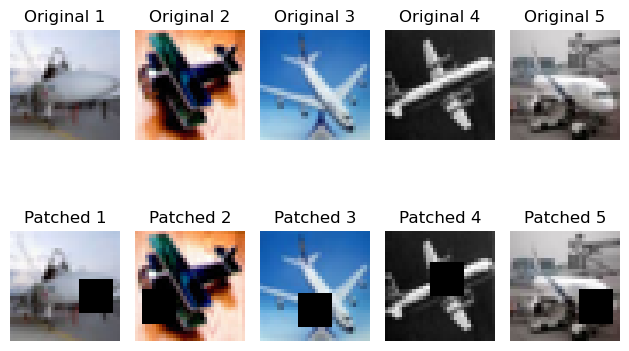

In [ ]:
import matplotlib.pyplot as plt

# show 5 og and then patched
for i, idx in enumerate(patched_images[:5]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cifar_train_data.data[idx])
    plt.title(f"Original {i + 1}")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(patched_cifar_train_data.data[idx])
    plt.title(f"Patched {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Train baseline model on unperturbed data for a baseline

*   List item
*   List item



# Train model from scratch with poisoned train data

In [ ]:
poisoned_net = torchvision.models.resnet18().to('cuda')
if LOAD:
    poisoned_net.load_state_dict(torch.load('models/poisoned_baseline'))
else:
    train(poisoned_net, 15, cifar_train_dl, cifar_test_dl)
    torch.save(poisoned_net.state_dict(), 'models/poisoned_baseline')

# Attempt to see if a poisoned image is misclassified
We patched planes with the backdoor patch. We will now patch a non-plane image in an attempt to have it misclassified as a plane.

In [ ]:
cifar_test_data.__dict__.keys()

dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets', 'classes', 'class_to_idx'])

In [ ]:
cifar_test_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# select a random image and then patch it.

targ_indexes = [i for i, x in enumerate(cifar_test_data.targets) if x == cifar_test_data.class_to_idx['frog']]
poison_target = copy.deepcopy(cifar_test_data.data[targ_indexes[0]])

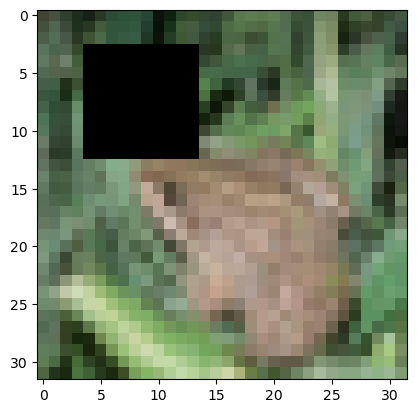

In [ ]:
patch_image(poison_target, 10, 3, 4)

plt.imshow(poison_target)
plt.show()

# Pick a representative subset with random

random Code taken heavily from the hw2 solutions

In [ ]:
#collapse
import numpy as np
import matplotlib
import random
# matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import time
import heapq

class FacilityLocation:
    def __init__(self, D, V):
        self.D = D
        self.V = V
        self.curVal = 0
        self.curMax = np.zeros(len(D))
        self.gains = []
        self.norm = self.inc([], V)

    def inc(self, sset, ndx):
        return np.maximum(self.curMax, self.D[:, ndx]).sum() - self.curVal

    def add(self, sset, ndx):
        cur_old = self.curVal

        self.curMax = np.maximum(self.curMax, self.D[:, ndx])
        self.curVal = self.curMax.sum()
        self.gains.extend([(self.curVal - cur_old) / self.norm])
        return self.curVal


def lazy_greedy(F, ndx, B):
    TOL = 1e-6
    eps = 1e-6
    curVal = 0
    sset = []
    order = []
    vals = []
    # print(f'ndx: {len(ndx)}')
    for v in ndx:
        marginal = F.inc(sset, v) + eps
        heapq.heappush(order, (1.0 / marginal, v, marginal))

    # print(f'order: {len(order)}')
    while order and len(sset) < B:
        el = heapq.heappop(order)
        if not sset:
            improv = el[2]
        else:
            improv = F.inc(sset, el[1]) + eps

        # check for uniques elements
        if improv > 0 + eps:
            if not order:
                curVal = F.add(sset, el[1])
                # print curVal
                # print(str(len(sset)) + ', ' + str(el[1]))
                sset.append(el[1])
                vals.append(curVal)
                # myfile.write(str(el[1]) + '\n')
            else:
                top = heapq.heappop(order)
                if improv >= top[2]:
                    curVal = F.add(sset, el[1])
                    # print curVal
                    # print(str(len(sset)) + ', ' + str(el[1]))
                    sset.append(el[1])
                    vals.append(curVal)
                    # myfile.write(str(el[1]) + '\n')
                else:
                    heapq.heappush(order, (1.0 / improv, el[1], improv))
                heapq.heappush(order, top)

    return sset, vals

# from [[https://github.com/sjoshi804/random-data-efficient-contrastive-learning/blob/master/random-pip/sas/subset_dataset.py]
def pairwise_distance(Z1: torch.tensor, Z2: torch.tensor, block_size: int = 512):
    similarity_matrices = []
    for i in range(Z1.shape[0] // block_size + 1):
        similarity_matrices_i = []
        e = Z1[i*block_size:(i+1)*block_size].flatten(start_dim=1)
        for j in range(Z2.shape[0] // block_size + 1):
            e_t = Z2[j*block_size:(j+1)*block_size].flatten(start_dim=1).t()
            similarity_matrices_i.append(
                np.array(
                torch.cosine_similarity(e[:, :, None], e_t[None, :, :]).detach().cpu()
                )
            )
        similarity_matrices.append(similarity_matrices_i)
    similarity_matrix = np.block(similarity_matrices)

    return similarity_matrix

# only this function needed to be modified
def call_greedy(data, percent):
    # need to go through every class
    full_set = [] # keeps track of every index that we want to keep for the subset
    for c in range(len(data.classes)):
        print('.', end='')
        targ_indexes = [i for i, x in enumerate(data.targets) if x == c] # get the index of each example in the class

        class_data = torch.tensor(data.data[targ_indexes], dtype=float).to('cuda') # class subset

        # compute D, cosine similarity between each image
        D = pairwise_distance(class_data, class_data)
        np.fill_diagonal(D, 0)
        print('*', end='')
        S = np.max(D) - D
        n = len(D)
        B = int(percent * len(targ_indexes)) # how many examples we want

        F = FacilityLocation(S, range(0, n))
        sset, vals = lazy_greedy(F, range(0, n), B)
        full_set.extend(np.array(targ_indexes)[sset]) # update the full set with what we want
        del D
        del S
        del F
        del vals
        del class_data

    # now modify the dataset to only have what was requested
    # data.data    = data.data[full_set]
    # data.targets = data.targets[full_set]
    return full_set


In [ ]:
# now grab a subset of X percent using the call_greedy on each subset
# probably get a subset at 25% 50% 75%
import copy
import csv

if LOAD:
    subset_25 = np.loadtxt("models/baseline_subset_25.csv", delimiter=',', dtype=int)
    subset_50 = np.loadtxt("models/baseline_subset_50.csv", delimiter=',', dtype=int)
    subset_75 = np.loadtxt("models/baseline_subset_75.csv", delimiter=',', dtype=int)
else:
    # need to be able to split the subset based on class
    print('\n-------25--------')
    subset_25 = call_greedy(cifar_train_data, .25)

    print('\n-------50--------')
    subset_50 = call_greedy(cifar_train_data, .5)

    print('\n-------75--------')
    subset_75 = call_greedy(cifar_train_data, .75)

    # save the subsets to disk
    np.savetxt("models/baseline_subset_25.csv", subset_25, delimiter=",")
    np.savetxt("models/baseline_subset_50.csv", subset_50, delimiter=",")
    np.savetxt("models/baseline_subset_75.csv", subset_75, delimiter=",")

In [ ]:
# now grab a subset of X percent using the call_greedy on each subset
# probably get a subset at 25% 50% 75%
import copy
import csv

if LOAD:
    poisoned_subset_25 = np.loadtxt("models/poisoned_subset_25.csv", delimiter=',', dtype=int)
    poisoned_subset_50 = np.loadtxt("models/poisoned_subset_50.csv", delimiter=',', dtype=int)
    poisoned_subset_75 = np.loadtxt("models/poisoned_subset_75.csv", delimiter=',', dtype=int)
else:
    # need to be able to split the subset based on class
    print('\n-------25--------')
    poisoned_subset_25 = call_greedy(patched_cifar_train_data, .25)

    print('\n-------50--------')
    poisoned_subset_50 = call_greedy(patched_cifar_train_data, .5)

    print('\n-------75--------')
    poisoned_subset_75 = call_greedy(patched_cifar_train_data, .75)

    np.savetxt("models/poisoned_subset_25.csv", poisoned_subset_25, delimiter=",")
    np.savetxt("models/poisoned_subset_50.csv", poisoned_subset_50, delimiter=",")
    np.savetxt("models/poisoned_subset_75.csv", poisoned_subset_75, delimiter=",")
#

In [ ]:
# use this to empty the GPU if need be
if CLEAR_CACHE:
    torch.cuda.empty_cache()

# Train a third model using the given subset

In [ ]:
sas_train_25_model = torchvision.models.resnet18().to('cuda')
sas_train_50_model = torchvision.models.resnet18().to('cuda')
sas_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

sas_train_25_data = copy.deepcopy(cifar_train_data)
sas_train_50_data = copy.deepcopy(cifar_train_data)
sas_train_75_data = copy.deepcopy(cifar_train_data)

make_subset(sas_train_25_data, subset_25)
make_subset(sas_train_50_data, subset_50)
make_subset(sas_train_75_data, subset_75)

sas_train_25_dl = torch.utils.data.DataLoader(sas_train_25_data, batch_size=batch_size, shuffle=True)
sas_train_50_dl = torch.utils.data.DataLoader(sas_train_50_data, batch_size=batch_size, shuffle=True)
sas_train_75_dl = torch.utils.data.DataLoader(sas_train_75_data, batch_size=batch_size, shuffle=True)


In [ ]:
if LOAD:
    sas_train_25_model.load_state_dict(torch.load('models/sas_train_25_baseline_model'))
    sas_train_50_model.load_state_dict(torch.load('models/sas_train_50_baseline_model'))
    sas_train_75_model.load_state_dict(torch.load('models/sas_train_75_baseline_model'))
else:
    train(sas_train_25_model, 15, sas_train_25_dl, cifar_test_dl)
    train(sas_train_50_model, 15, sas_train_50_dl, cifar_test_dl)
    train(sas_train_75_model, 15, sas_train_75_dl, cifar_test_dl)

    torch.save(sas_train_25_model.state_dict(), 'models/sas_train_25_baseline_model')
    torch.save(sas_train_50_model.state_dict(), 'models/sas_train_50_baseline_model')
    torch.save(sas_train_75_model.state_dict(), 'models/sas_train_75_baseline_model')
#

In [ ]:
# get just random subsets of 25%, 50%, and 75% as well
# compare them against the performance of SAS
random_25 = random.sample(range(len(cifar_train_data.data)), 12500)
random_50 = random.sample(range(len(cifar_train_data.data)), 25000)
random_75 = random.sample(range(len(cifar_train_data.data)), 37500)

In [ ]:
random_train_25_model = torchvision.models.resnet18().to('cuda')
random_train_50_model = torchvision.models.resnet18().to('cuda')
random_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

random_train_25_data = copy.deepcopy(cifar_train_data)
random_train_50_data = copy.deepcopy(cifar_train_data)
random_train_75_data = copy.deepcopy(cifar_train_data)

make_subset(random_train_25_data, random_25)
make_subset(random_train_50_data, random_50)
make_subset(random_train_75_data, random_75)

random_train_25_dl = torch.utils.data.DataLoader(random_train_25_data, batch_size=batch_size, shuffle=True)
random_train_50_dl = torch.utils.data.DataLoader(random_train_50_data, batch_size=batch_size, shuffle=True)
random_train_75_dl = torch.utils.data.DataLoader(random_train_75_data, batch_size=batch_size, shuffle=True)

In [ ]:
if LOAD:
    random_train_25_model.load_state_dict(torch.load('models/random_train_25_baseline_model'))
    random_train_50_model.load_state_dict(torch.load('models/random_train_50_baseline_model'))
    random_train_75_model.load_state_dict(torch.load('models/random_train_75_baseline_model'))
else:
    train(random_train_25_model, 15, random_train_25_dl, cifar_test_dl)
    train(random_train_50_model, 15, random_train_50_dl, cifar_test_dl)
    train(random_train_75_model, 15, random_train_75_dl, cifar_test_dl)

    torch.save(random_train_25_model.state_dict(), 'models/random_train_25_baseline_model')
    torch.save(random_train_50_model.state_dict(), 'models/random_train_50_baseline_model')
    torch.save(random_train_75_model.state_dict(), 'models/random_train_75_baseline_model')
#

\# test that against the poison model

In [ ]:
# remaining : sas training on the poisoned stuff
sas_poisoned_train_25_model = torchvision.models.resnet18().to('cuda')
sas_poisoned_train_50_model = torchvision.models.resnet18().to('cuda')
sas_poisoned_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

sas_poisoned_train_25_data = copy.deepcopy(patched_cifar_train_data)
sas_poisoned_train_50_data = copy.deepcopy(patched_cifar_train_data)
sas_poisoned_train_75_data = copy.deepcopy(patched_cifar_train_data)

make_subset(sas_poisoned_train_25_data, poisoned_subset_25)
make_subset(sas_poisoned_train_50_data, poisoned_subset_50)
make_subset(sas_poisoned_train_75_data, poisoned_subset_75)

sas_poisoned_train_25_dl = torch.utils.data.DataLoader(sas_poisoned_train_25_data, batch_size=batch_size, shuffle=True)
sas_poisoned_train_50_dl = torch.utils.data.DataLoader(sas_poisoned_train_50_data, batch_size=batch_size, shuffle=True)
sas_poisoned_train_75_dl = torch.utils.data.DataLoader(sas_poisoned_train_75_data, batch_size=batch_size, shuffle=True)

In [ ]:
if LOAD:
    sas_poisoned_train_25_model.load_state_dict(torch.load('models/sas_poisoned_train_25_baseline_model'))
    sas_poisoned_train_50_model.load_state_dict(torch.load('models/sas_poisoned_train_50_baseline_model'))
    sas_poisoned_train_75_model.load_state_dict(torch.load('models/sas_poisoned_train_75_baseline_model'))
else:
    train(sas_poisoned_train_25_model, 15, sas_poisoned_train_25_dl, cifar_test_dl)
    train(sas_poisoned_train_50_model, 15, sas_poisoned_train_50_dl, cifar_test_dl)
    train(sas_poisoned_train_75_model, 15, sas_poisoned_train_75_dl, cifar_test_dl)

    torch.save(sas_poisoned_train_25_model.state_dict(), 'models/sas_poisoned_train_25_baseline_model')
    torch.save(sas_poisoned_train_50_model.state_dict(), 'models/sas_poisoned_train_50_baseline_model')
    torch.save(sas_poisoned_train_75_model.state_dict(), 'models/sas_poisoned_train_75_baseline_model')
#

	Test accuracy for epoch 1: 0.2999
	Test accuracy for epoch 2: 0.3432
	Test accuracy for epoch 3: 0.3513
	Test accuracy for epoch 4: 0.3671
	Test accuracy for epoch 5: 0.3731
	Test accuracy for epoch 6: 0.3786
	Test accuracy for epoch 7: 0.3839
	Test accuracy for epoch 8: 0.3764
	Test accuracy for epoch 9: 0.3774
	Test accuracy for epoch 10: 0.3796
	Test accuracy for epoch 11: 0.3806
	Test accuracy for epoch 12: 0.3767
	Test accuracy for epoch 13: 0.3782
	Test accuracy for epoch 14: 0.3773
	Test accuracy for epoch 15: 0.3790
	Test accuracy for epoch 1: 0.3490
	Test accuracy for epoch 2: 0.4021
	Test accuracy for epoch 3: 0.4232
	Test accuracy for epoch 4: 0.4337
	Test accuracy for epoch 5: 0.4467
	Test accuracy for epoch 6: 0.4504
	Test accuracy for epoch 7: 0.4440
	Test accuracy for epoch 8: 0.4432
	Test accuracy for epoch 9: 0.4489
	Test accuracy for epoch 10: 0.4456
	Test accuracy for epoch 11: 0.4489
	Test accuracy for epoch 12: 0.4497
	Test accuracy for epoch 13: 0.4498
	Test accu

In [ ]:
if LOAD:
    sas_train_25_model.load_state_dict(torch.load('models/sas_train_25_baseline_model'))
    sas_train_50_model.load_state_dict(torch.load('models/sas_train_50_baseline_model'))
    sas_train_75_model.load_state_dict(torch.load('models/sas_train_75_baseline_model'))
else:
    train(sas_train_25_model, 15, sas_train_25_dl, cifar_test_dl)
    train(sas_train_50_model, 15, sas_train_50_dl, cifar_test_dl)
    train(sas_train_75_model, 15, sas_train_75_dl, cifar_test_dl)

    torch.save(sas_train_25_model.state_dict(), 'models/sas_train_25_baseline_model')
    torch.save(sas_train_50_model.state_dict(), 'models/sas_train_50_baseline_model')
    torch.save(sas_train_75_model.state_dict(), 'models/sas_train_75_baseline_model')
#

In [ ]:
# random training on the poison
random_poisoned_train_25_model = torchvision.models.resnet18().to('cuda')
random_poisoned_train_50_model = torchvision.models.resnet18().to('cuda')
random_poisoned_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

random_poisoned_train_25_data = copy.deepcopy(patched_cifar_train_data)
random_poisoned_train_50_data = copy.deepcopy(patched_cifar_train_data)
random_poisoned_train_75_data = copy.deepcopy(patched_cifar_train_data)

make_subset(random_poisoned_train_25_data, random_25)
make_subset(random_poisoned_train_50_data, random_50)
make_subset(random_poisoned_train_75_data, random_75)

random_poisoned_train_25_dl = torch.utils.data.DataLoader(random_poisoned_train_25_data, batch_size=batch_size, shuffle=True)
random_poisoned_train_50_dl = torch.utils.data.DataLoader(random_poisoned_train_50_data, batch_size=batch_size, shuffle=True)
random_poisoned_train_75_dl = torch.utils.data.DataLoader(random_poisoned_train_75_data, batch_size=batch_size, shuffle=True)

In [ ]:
if LOAD:
    random_poisoned_train_25_model.load_state_dict(torch.load('models/random_poisoned_train_25_baseline_model'))
    random_poisoned_train_50_model.load_state_dict(torch.load('models/random_poisoned_train_50_baseline_model'))
    random_poisoned_train_75_model.load_state_dict(torch.load('models/random_poisoned_train_75_baseline_model'))
else:
    train(random_poisoned_train_25_model, 15, random_poisoned_train_25_dl, cifar_test_dl)
    train(random_poisoned_train_50_model, 15, random_poisoned_train_50_dl, cifar_test_dl)
    train(random_poisoned_train_75_model, 15, random_poisoned_train_75_dl, cifar_test_dl)

    torch.save(random_poisoned_train_25_model.state_dict(), 'models/random_poisoned_train_25_baseline_model')
    torch.save(random_poisoned_train_50_model.state_dict(), 'models/random_poisoned_train_50_baseline_model')
    torch.save(random_poisoned_train_75_model.state_dict(), 'models/random_poisoned_train_75_baseline_model')
#

In [ ]:
import pandas as pd

models = [
    net,
    poisoned_net,
    sas_train_25_model,
    sas_train_50_model,
    sas_train_75_model,
    sas_poisoned_train_25_model,
    sas_poisoned_train_50_model,
    sas_poisoned_train_75_model,
    random_train_25_model,
    random_train_50_model,
    random_train_75_model,
    random_poisoned_train_25_model,
    random_poisoned_train_50_model,
    random_poisoned_train_75_model,
]
model_names = [
    'baseline_model',
    'poisoned_baseline',
    'sas_train_25_model',
    'sas_train_50_model',
    'sas_train_75_model',
    'sas_poisoned_train_25_model',
    'sas_poisoned_train_50_model',
    'sas_poisoned_train_75_model',
    'random_train_25_model',
    'random_train_50_model',
    'random_train_75_model',
    'random_poisoned_train_25_model',
    'random_poisoned_train_50_model',
    'random_poisoned_train_75_model',
]

[x.eval() for x in models]

results = {}
results['Model'] = model_names
results['Baseline Test (Top 1 Accuracy)'] = []
results['Patched Test (Top 1 Accuracy)'] = []
for model, name in zip(models, model_names):
    results['Baseline Test (Top 1 Accuracy)'].append(test(model, cifar_test_dl))
    results['Patched Test (Top 1 Accuracy)'].append(test(model, patched_cifar_test_dl))

df = pd.DataFrame(results)
df

KeyboardInterrupt: 

# Work on the forgettable and unforgettable events

Forgettable events w/o poison:

In [ ]:
# now grab a subset of X percent using the call_greedy on each subset
# probably get a subset at 25% 50% 75%
import copy
import csv

LOAD = False
if LOAD:
    forgets_subset_25 = np.loadtxt("models/forgets_subset_25.csv", delimiter=',', dtype=int)
    forgets_subset_50 = np.loadtxt("models/forgets_subset_50.csv", delimiter=',', dtype=int)
    forgets_subset_75 = np.loadtxt("models/forgets_subset_75.csv", delimiter=',', dtype=int)
else:
    # need to be able to split the subset based on class
    print('\n-------25--------')
    forgets_subset_25 = call_greedy(forgets, .25)

    print('\n-------50--------')
    forgets_subset_50 = call_greedy(forgets, .5)

    print('\n-------75--------')
    forgets_subset_75 = call_greedy(forgets, .75)

    # save the subsets to disk
    np.savetxt("models/forgets_subset_25.csv", forgets_subset_25, delimiter=",")
    np.savetxt("models/forgettables_subset_50.csv", forgets_subset_50, delimiter=",")
    np.savetxt("models/forgettables_subset_75.csv", forgets_subset_75, delimiter=",")

In [ ]:
forgets_train_25_model = torchvision.models.resnet18().to('cuda')
forgets_train_50_model = torchvision.models.resnet18().to('cuda')
forgets_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

forgets_train_25_data = copy.deepcopy(cifar_train_data)
forgets_train_50_data = copy.deepcopy(cifar_train_data)
forgets_train_75_data = copy.deepcopy(cifar_train_data)

make_subset(forgets_train_25_data, forgets_subset_25)
make_subset(forgets_train_50_data, forgets_subset_50)
make_subset(forgets_train_75_data, forgets_subset_75)

forgets_train_25_dl = torch.utils.data.DataLoader(forgets_train_25_data, batch_size=batch_size, shuffle=True)
forgets_train_50_dl = torch.utils.data.DataLoader(forgets_train_50_data, batch_size=batch_size, shuffle=True)
forgets_train_75_dl = torch.utils.data.DataLoader(forgets_train_75_data, batch_size=batch_size, shuffle=True)


In [ ]:
if LOAD:
    forgets_train_25_model.load_state_dict(torch.load('models/forgets_train_25_baseline_model'))
    forgets_train_50_model.load_state_dict(torch.load('models/forgets_train_50_baseline_model'))
    forgets_train_75_model.load_state_dict(torch.load('models/forgets_train_75_baseline_model'))
else:
    train(forgets_train_25_model, 15, forgets_train_25_dl, cifar_test_dl)
    train(forgets_train_50_model, 15, forgets_train_50_dl, cifar_test_dl)
    train(forgets_train_75_model, 15, forgets_train_75_dl, cifar_test_dl)

    torch.save(forgets_train_25_model.state_dict(), 'models/forgets_train_25_baseline_model')
    torch.save(forgets_train_50_model.state_dict(), 'models/forgets_train_50_baseline_model')
    torch.save(forgets_train_75_model.state_dict(), 'models/forgets_train_75_baseline_model')

Unforgettable events w/o poison:

In [ ]:
# now grab a subset of X percent using the call_greedy on each subset
# probably get a subset at 25% 50% 75%
import copy
import csv

LOAD = False
if LOAD:
    unforgets_subset_25 = np.loadtxt("models/unforgets_subset_25.csv", delimiter=',', dtype=int)
    unforgets_subset_50 = np.loadtxt("models/unforgets_subset_50.csv", delimiter=',', dtype=int)
    unforgets_subset_75 = np.loadtxt("models/unforgets_subset_75.csv", delimiter=',', dtype=int)
else:
    # need to be able to split the subset based on class
    print('\n-------25--------')
    unforgets_subset_25 = call_greedy(unforgets, .25)

    print('\n-------50--------')
    unforgets_subset_50 = call_greedy(unforgets, .5)

    print('\n-------75--------')
    unforgets_subset_75 = call_greedy(unforgets, .75)

    # save the subsets to disk
    np.savetxt("models/unforgets_subset_25.csv", unforgets_subset_25, delimiter=",")
    np.savetxt("models/unforgettables_subset_50.csv", unforgets_subset_50, delimiter=",")
    np.savetxt("models/unforgettables_subset_75.csv", unforgets_subset_75, delimiter=",")

In [ ]:
unforgets_train_25_model = torchvision.models.resnet18().to('cuda')
unforgets_train_50_model = torchvision.models.resnet18().to('cuda')
unforgets_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

unforgets_train_25_data = copy.deepcopy(cifar_train_data)
unforgets_train_50_data = copy.deepcopy(cifar_train_data)
unforgets_train_75_data = copy.deepcopy(cifar_train_data)

make_subset(unforgets_train_25_data, unforgets_subset_25)
make_subset(unforgets_train_50_data, unforgets_subset_50)
make_subset(unforgets_train_75_data, unforgets_subset_75)

unforgets_train_25_dl = torch.utils.data.DataLoader(unforgets_train_25_data, batch_size=batch_size, shuffle=True)
unforgets_train_50_dl = torch.utils.data.DataLoader(unforgets_train_50_data, batch_size=batch_size, shuffle=True)
unforgets_train_75_dl = torch.utils.data.DataLoader(unforgets_train_75_data, batch_size=batch_size, shuffle=True)


In [ ]:
if LOAD:
    unforgets_train_25_model.load_state_dict(torch.load('models/unforgets_train_25_baseline_model'))
    unforgets_train_50_model.load_state_dict(torch.load('models/unforgets_train_50_baseline_model'))
    unforgets_train_75_model.load_state_dict(torch.load('models/unforgets_train_75_baseline_model'))
else:
    train(unforgets_train_25_model, 15, unforgets_train_25_dl, cifar_test_dl)
    train(unforgets_train_50_model, 15, unforgets_train_50_dl, cifar_test_dl)
    train(unforgets_train_75_model, 15, unforgets_train_75_dl, cifar_test_dl)

    torch.save(unforgets_train_25_model.state_dict(), 'models/unforgets_train_25_baseline_model')
    torch.save(unforgets_train_50_model.state_dict(), 'models/unforgets_train_50_baseline_model')
    torch.save(unforgets_train_75_model.state_dict(), 'models/unforgets_train_75_baseline_model')

Forgettable events w/ poison:

In [ ]:
# Apply patch the forgettable events
patch_size = 10

patched_forgets_train_data = copy.deepcopy(forgets)
patched_forgets_images = apply_patch(patched_forgets_train_data, patch_size)

patched_forgets_train_dl = torch.utils.data.DataLoader(patched_forgets_train_data, batch_size=batch_size, shuffle=True)

In [ ]:
# now grab a subset of X percent using the call_greedy on each subset
# probably get a subset at 25% 50% 75%
import copy
import csv

if LOAD:
    forgets_poisoned_subset_25 = np.loadtxt("models/forgets_poisoned_subset_25.csv", delimiter=',', dtype=int)
    forgets_poisoned_subset_50 = np.loadtxt("models/forgets_poisoned_subset_50.csv", delimiter=',', dtype=int)
    forgets_poisoned_subset_75 = np.loadtxt("models/forgets_poisoned_subset_75.csv", delimiter=',', dtype=int)
else:
    # need to be able to split the subset based on class
    print('\n-------25--------')
    forgets_poisoned_subset_25 = call_greedy(patched_forgets_train_data, .25)

    print('\n-------50--------')
    forgets_poisoned_subset_50 = call_greedy(patched_forgets_train_data, .5)

    print('\n-------75--------')
    forgets_poisoned_subset_75 = call_greedy(patched_forgets_train_data, .75)

    np.savetxt("models/forgets_poisoned_subset_25.csv", forgets_poisoned_subset_25, delimiter=",")
    np.savetxt("models/forgets_poisoned_subset_50.csv", forgets_poisoned_subset_50, delimiter=",")
    np.savetxt("models/forgets_poisoned_subset_75.csv", forgets_poisoned_subset_75, delimiter=",")
#

In [ ]:
# remaining : sas training on the forgettable poisoned stuff
forgets_poisoned_train_25_model = torchvision.models.resnet18().to('cuda')
forgets_poisoned_train_50_model = torchvision.models.resnet18().to('cuda')
forgets_poisoned_train_75_model = torchvision.models.resnet18().to('cuda')

def make_subset(data, subset):
    data.data = data.data[subset]
    data.targets = [data.targets[x] for x in subset]

forgets_poisoned_train_25_data = copy.deepcopy(patched_forgets_train_data)
forgets_poisoned_train_50_data = copy.deepcopy(patched_forgets_train_data)
forgets_poisoned_train_75_data = copy.deepcopy(patched_forgets_train_data)

make_subset(forgets_poisoned_train_25_data, forgets_poisoned_subset_25)
make_subset(forgets_poisoned_train_50_data, forgets_poisoned_subset_50)
make_subset(forgets_poisoned_train_75_data, forgets_poisoned_subset_75)

forgets_poisoned_train_25_dl = torch.utils.data.DataLoader(forgets_poisoned_train_25_data, batch_size=batch_size, shuffle=True)
forgets_poisoned_train_50_dl = torch.utils.data.DataLoader(forgets_poisoned_train_50_data, batch_size=batch_size, shuffle=True)
forgets_poisoned_train_75_dl = torch.utils.data.DataLoader(forgets_poisoned_train_75_data, batch_size=batch_size, shuffle=True)

In [ ]:
#Trying to debug, get an error because of "data type"

if LOAD:
    forgets_poisoned_train_25_model.load_state_dict(torch.load('models/forgets_poisoned_train_25_baseline_model'))
    forgets_poisoned_train_50_model.load_state_dict(torch.load('models/forgets_poisoned_train_50_baseline_model'))
    forgets_poisoned_train_75_model.load_state_dict(torch.load('models/forgets_poisoned_train_75_baseline_model'))
else:
    train(forgets_poisoned_train_25_model, 15, forgets_poisoned_train_25_dl, cifar_test_dl)
    train(forgets_poisoned_train_50_model, 15, forgets_poisoned_train_50_dl, cifar_test_dl)
    train(forgets_poisoned_train_75_model, 15, forgets_poisoned_train_75_dl, cifar_test_dl)

    torch.save(forgets_poisoned_train_25_model.state_dict(), 'models/forgets_poisoned_train_25_baseline_model')
    torch.save(forgets_poisoned_train_50_model.state_dict(), 'models/forgets_poisoned_train_50_baseline_model')
    torch.save(forgets_poisoned_train_75_model.state_dict(), 'models/forgets_poisoned_train_75_baseline_model')
#

In [ ]:
print(len(cifar_train_dl)*256)

50176


In [ ]:
print(len(forgettables_indices))
print(len(unforgettables_indices))

print(forgettables_indices)
# print(unforgettables_indices)

192
749808
[8424, 11239, 14066, 14821, 17009, 17017, 17216, 17237, 17996, 18306, 20211, 20865, 24013, 30835, 33615, 37337, 37382, 38015, 38813, 40153, 43196, 44395, 45394, 45790, 46234, 46987, 48265, 48963, 49986, 2017, 4636, 6201, 7734, 8708, 9929, 9972, 10867, 12085, 13416, 13643, 13674, 14630, 17614, 18664, 18670, 18702, 18740, 18764, 18858, 18878, 19255, 19716, 19733, 19877, 22862, 23389, 23565, 24487, 25414, 32394, 35812, 35833, 35971, 37467, 42929, 45002, 836, 2953, 3144, 8850, 8976, 12598, 12621, 12640, 12668, 15161, 20903, 21060, 21233, 22488, 23394, 24285, 24296, 25439, 26850, 26895, 28435, 30438, 31189, 35639, 9110, 28705, 41663, 42501, 7665, 27923, 29797, 30309, 30328, 30373, 30391, 33638, 38647, 40787, 40871, 41916, 43060, 50709, 50731, 50757, 2252, 2306, 2371, 2525, 2640, 2796, 3078, 4690, 4700, 4728, 7218, 7573, 8339, 11157, 11284, 13093, 15442, 15463, 15518, 17387, 24188, 26360, 26406, 27982, 35961, 36819, 39137, 39296, 1664, 2744, 8443, 20782, 30144, 43971, 46372, 47664

In [ ]:
## Get the forgettable data in OG data
def forgettable_events(dataset, forgettables_indices):
    for idx, x in enumerate(forgettables_indices):
      image = dataset.data[x] ##Todo: check forgettale indices code bc it is out of range :(
      print(idx, x)

    return forgettables_indices


forgettables_indices, unforgettables_indices = train(net, 15, cifar_train_dl, cifar_test_dl)

forgettables_cifar_train_data = copy.deepcopy(cifar_train_data)
forgettables_images = forgettable_events(forgettables_cifar_train_data, forgettables_indices)

forgetttables_cifar_train_dl = torch.utils.data.DataLoader(forgettables_cifar_train_data, batch_size=batch_size, shuffle=True)

0 8424
1 11239
2 14066
3 14821
4 17009
5 17017
6 17216
7 17237
8 17996
9 18306
10 20211
11 20865
12 24013
13 30835
14 33615
15 37337
16 37382
17 38015
18 38813
19 40153
20 43196
21 44395
22 45394
23 45790
24 46234
25 46987
26 48265
27 48963
28 49986
29 2017
30 4636
31 6201
32 7734
33 8708
34 9929
35 9972
36 10867
37 12085
38 13416
39 13643
40 13674
41 14630
42 17614
43 18664
44 18670
45 18702
46 18740
47 18764
48 18858
49 18878
50 19255
51 19716
52 19733
53 19877
54 22862
55 23389
56 23565
57 24487
58 25414
59 32394
60 35812
61 35833
62 35971
63 37467
64 42929
65 45002
66 836
67 2953
68 3144
69 8850
70 8976
71 12598
72 12621
73 12640
74 12668
75 15161
76 20903
77 21060
78 21233
79 22488
80 23394
81 24285
82 24296
83 25439
84 26850
85 26895
86 28435
87 30438
88 31189
89 35639
90 9110
91 28705
92 41663
93 42501
94 7665
95 27923
96 29797
97 30309
98 30328
99 30373
100 30391
101 33638
102 38647
103 40787
104 40871
105 41916
106 43060


IndexError: index 50709 is out of bounds for axis 0 with size 50000